In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' # hides the GPU from tensorflow (for science)
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from extra_keras_datasets import emnist

In [2]:
# Get EMNIST by Class
(X_train, y_train), (X_test, y_test) = emnist.load_data(type='byclass')
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)
labels = { int(line.split()[0]) : int(line.split()[1]) for line in open("../emnist-byclass-mapping.txt") }

INFO:root:Loading dataset = emnist


(697932, 28, 28) (697932,) (116323, 28, 28) (697932,)


In [3]:
def rotate(arr):
    for i in range(len(arr)):
        arr[i] = arr[i].swapaxes(-2,-1)[...,::-1]

    return arr

# Flip and rotate image
# X_train = rotate(X_train)
# X_test = rotate(X_test)

# Normalize pixels
X_train = X_train / 255.0
X_test = X_test / 255.0

# Expand dims
X_train = tf.expand_dims(X_train, 3)
X_test = tf.expand_dims(X_test, 3)

# Convert y values to categorical one hot
num_classes = len(np.unique(y_train))
# y_train = np_utils.to_categorical(y_train, num_classes)
# y_test = np_utils.to_categorical(y_test, num_classes)

# Slice part of train as validation set
X_val = X_train[:5000]
y_val = y_train[:5000]

2021-12-05 01:45:16.014651: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(X_train.shape, y_train.shape, X_test.shape, y_train.shape)

(697932, 28, 28, 1) (697932,) (116323, 28, 28, 1) (697932,)


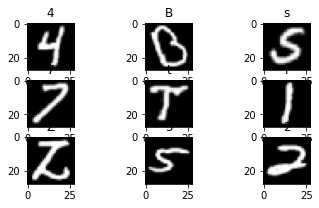

In [5]:
# plot image
for i in range(100, 109):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.title(chr(labels[y_train[i]]))

In [6]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(5,5), strides=1,  activation='relu', input_shape=X_train[0].shape, padding='same'), #C1
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2)), #S2
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'), #C3
    keras.layers.AveragePooling2D(pool_size=(2,2)), #S4
    keras.layers.Flatten(), #Flatten
    keras.layers.Dense(units=128, activation='relu'), #C5
    keras.layers.Dropout(0.5), #F6
    keras.layers.Dense(units=num_classes, activation='softmax') #Output layer
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 128)       3328      
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 128)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        73792     
                                                                 
 average_pooling2d_1 (Averag  (None, 7, 7, 64)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 128)               4

In [7]:
model.compile(
    optimizer='adam', 
    loss=keras.losses.sparse_categorical_crossentropy, 
    metrics=['accuracy']
)

In [8]:
# model.fit(
#     X_train, 
#     y_train, 
#     epochs=100, 
#     validation_data=(X_val, y_val),
#     callbacks = [
#         tf.keras.callbacks.EarlyStopping(
#             monitor='val_loss', 
#             patience = 5
#         )
#     ]
# )

# create an image generator and batches
# datagen = ImageDataGenerator(rotation_range=60, zoom_range=(0.9, 1.1), \
#                             width_shift_range=0.2, height_shift_range=0.2)
datagen = ImageDataGenerator()
datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit_generator(train_gen, steps_per_epoch=len(X_train)/32, epochs=20, validation_data=(X_val, y_val))

/Users/jujubear/Documents/SBU/2021-2022 S1/CSE 518/CSE518/Project/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
21810/21810 [==============================] - 2324s 107ms/step - loss: 0.6423 - accuracy: 0.7942 - val_loss: 0.3864 - val_accuracy: 0.8516
Epoch 2/20
21810/21810 [==============================] - 2142s 98ms/step - loss: 0.4723 - accuracy: 0.8385 - val_loss: 0.3622 - val_accuracy: 0.8580
Epoch 3/20
21810/21810 [==============================] - 1084s 50ms/step - loss: 0.4416 - accuracy: 0.8467 - val_loss: 0.3491 - val_accuracy: 0.8658
Epoch 4/20
21810/21810 [==============================] - 1057s 48ms/step - loss: 0.4285 - accuracy: 0.8509 - val_loss: 0.3454 - val_accuracy: 0.8690
Epoch 5/20
21810/21810 [==============================] - 1008s 46ms/step - loss: 0.4195 - accuracy: 0.8534 - val_loss: 0.3379 - val_accuracy: 0.8712
Epoch 6/20
21810/21810 [==============================] - 987s 45ms/step - loss: 0.4139 - accuracy: 0.8549 - val_loss: 0.3359 - val_accuracy: 0.8716
Epoch 7/20
21810/21810 [==============================] - 969s 44ms/step - loss: 0.4098 - accuracy: 

In [9]:
loss, acc = model.evaluate(X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

3636/3636 - 41s - loss: 0.3797 - accuracy: 0.8671 - 41s/epoch - 11ms/step
Restored model, accuracy: 86.71%


In [1]:
# plot accuracy and loss
def plotgraph(epochs, acc, val_acc):
    # Plot training & validation accuracy values
    plt.plot(epochs, acc, 'b')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,len(acc)+1)

# Accuracy curve
plotgraph(epochs, acc, val_acc)

# loss curve
plotgraph(epochs, loss, val_loss)

NameError: name 'history' is not defined

In [ ]:
model.save("final_model")

2021-11-24 09:26:16.704781: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: final_model/assets


INFO:tensorflow:Assets written to: final_model/assets


In [2]:
m = tf.keras.models.load_model("final_model")

2021-12-14 05:52:50.407338: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


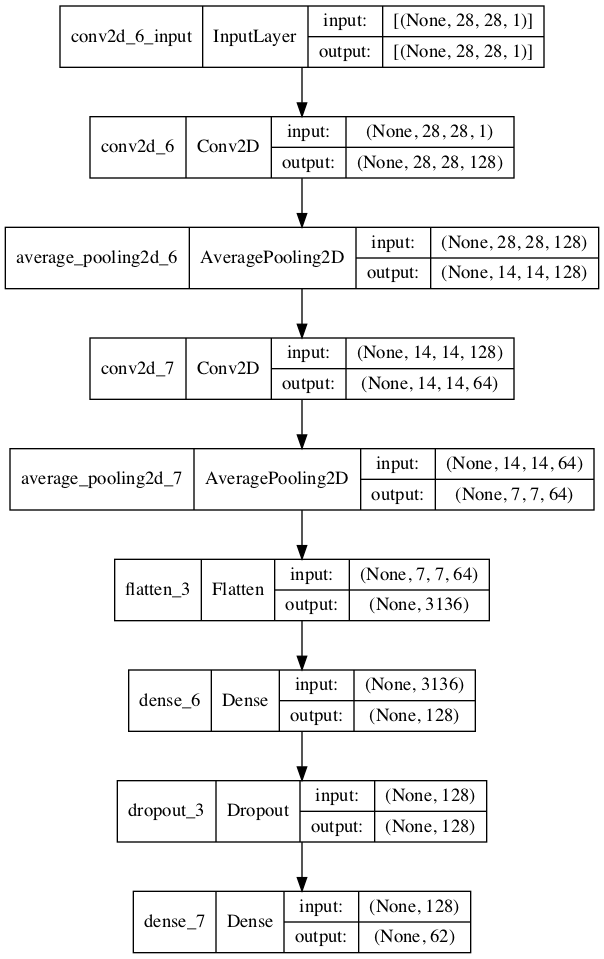

In [3]:
tf.keras.utils.plot_model(m, show_shapes=True, show_layer_names=True, dpi=96)